In [1]:
import sys,os
sys.path.append('..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam
from backtester.swarms import SwarmManager, SwarmRanker

import pandas as pd
import numpy as np
import scipy

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
strategyname = 'strategy_880131'
d, info = matlab.loaddata('../mat/'+strategyname+'.mat')

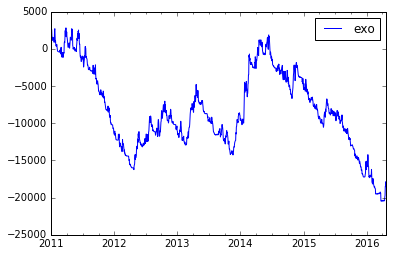

In [4]:
d.plot()

In [5]:
info

{'legs': 3,
 'name': 'CallSpread',
 'pcf': array([0, 0, 2], dtype=uint8),
 'pcfqty': array([ 1, -1,  0], dtype=int16),
 'tickincrement': 0.001,
 'tickvalue': 10,
 'underlying': 'NGE'}

# Class based strategy

* Enter short when fast MA crosses down slow MA
* Exit when fast MA crosses up slow MA + median trailing stop


In [6]:
class StrategyMACrossTrail(StrategyBase):
    def __init__(self):
        # Initialize parent class
        super().__init__()
        
        # Define system's name
        self.name = 'MA Crossing with trailing stop'
        
        # This is a short strategy
        self.direction = 1
        
        # Define optimized params
        self.opts = [
            #OptParam(name, default_value, min_value, max_value, step)
            OptParam('SlowMAPeriod', 20, 10, 30, 2),
            OptParam('FastMAPeriod', 2, 2, 20, 1),
            OptParam('MedianPeriod', 5, 5, 20, 3)
        ]
        
        self.initialize()
        
    def initialize(self):
        #
        #  Loading EXO quotes from .mat file
        #
        strategyname = 'strategy_880131'
        self.data, info = matlab.loaddata('../mat/'+strategyname+'.mat')
        
        #
        # Estimating transaction costs in base points of price
        #
        
        # No costs
        self.costs = pd.Series(0, self.data.index)
        
        # Flat costs / 1 point of EXO price per side / 2 roundtrip
        #self.costs = pd.Series(1, self.data.index)
        
        # Dynamic costs (we could utilize dynamic costs models)
        #  Like slippage calculation on bid/ask data / etc
        # Some meta code (just in my imagination)
        # costmanager = CostManager('EXO.Ticker').LoadSlippageFromDB('2000-01-01', now)
        # self.costs = costmanager.getslippage() + pd.Series(0.1, self.data.index) # Slippage + commission
        
    @property
    def positionsize(self):
        """
        Returns volatility adjuster positions size for strategy
        :return:
        """
        # Defining EXO price
        px = self.data.exo

        # Calculate position size adjusted to volatility of EXO
        # Dollar risk per 1 volatility unit
        risk_perunit = 100
        risk_vola_period = 60

        # Calculate volatility unit
        # In this case we use 10-period rolling median of EXO changes
        vola = abs(px.diff()).rolling(risk_vola_period).median()
        # We want to risk 100$ per 1 volatility unit
        #
        # This type of position sizing used for calibration of swarm members
        # After swarm generation and picking we will use portfolio based MM by Van Tharp
        # Tailored for portfolio size and risks of particular client
        return risk_perunit / vola
    
    def calculate(self, params=None):
        #        
        #
        #  Params is a tripple like (50, 10, 15), where:
        #   50 - slow MA period
        #   10 - fast MA period
        #   15 - median period
        #
        #  On every iteration of swarming algorithm, parameter set will be different.
        #  For more information look inside: /notebooks/tmp/Swarming engine research.ipynb
        #       
        
        if params is None:
            # Return default parameters
            period_slow, period_fast, period_median = self.default_opts()
        else:
            # Unpacking optimization params
            #  in order in self.opts definition
            period_slow, period_fast, period_median = params
        
        # Defining EXO price
        px = self.data.exo
        
        #
        #
        # Indicator calculation
        #
        #
        slow_ma = px.rolling(period_slow).mean()
        fast_ma = px.rolling(period_fast).mean()
        # Median based trailing stop
        trailing_stop = px.rolling(period_median).median().shift(1)        
    
        # Enry/exit rules
        entry_rule = CrossDown(fast_ma, slow_ma)
        exit_rule = (CrossUp(fast_ma, slow_ma) ) | (CrossUp(px, trailing_stop))
        
        # Swarm_member_name must be *unique* for every swarm member
        # We use params values for uniqueness 
        swarm_member_name = str((period_slow, period_fast, period_median))        
        
        return swarm_member_name, entry_rule, exit_rule
        

<h1>Backtest results</h2>

In [7]:
# Initiate the strategy

strategy = StrategyMACrossTrail()

In [9]:
# Running all parameters permutations in swarm
swarm, swarm_stats, swarm_inposition = strategy.run_swarm()

In [10]:
# Saving swarm for future use
swarm.to_hdf('../swarms/macross_trailing.h5', 'swarm')

# Analyze the swarm

In [11]:
swarm = pd.read_hdf('../swarms/macross_trailing.h5', 'swarm')

### Exploriong swarm bounds

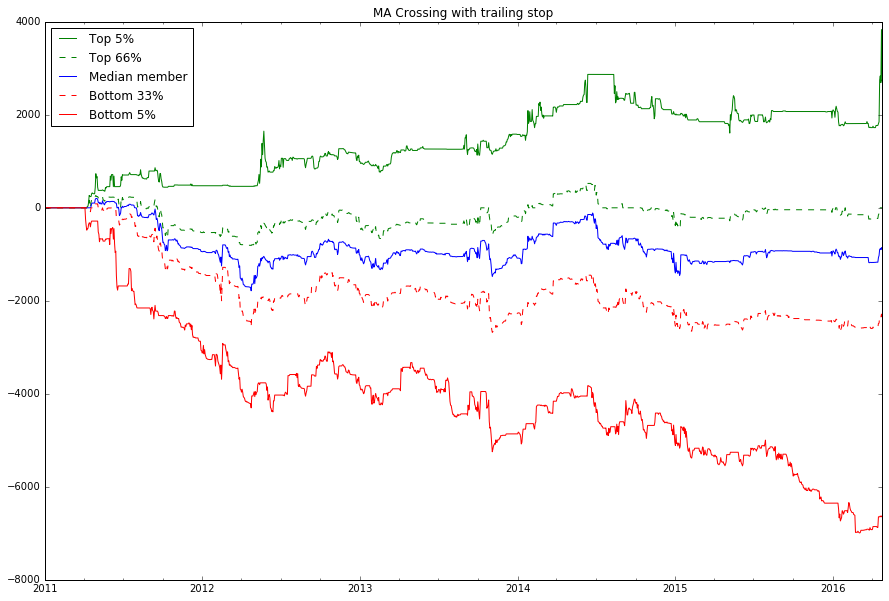

In [12]:
figsize(15,10)
title(strategy.name)
swarm.apply(lambda x: np.percentile(x, q=95), axis=1).plot(label='Top 5%', c='g')
swarm.apply(lambda x: np.percentile(x, q=66), axis=1).plot(label='Top 66%', c='g', style='k--')
swarm.apply(np.median, axis=1).plot(label='Median member')
swarm.apply(lambda x: np.percentile(x, q=33), axis=1).plot(label='Bottom 33%', c='r', style='k--')
swarm.apply(lambda x: np.percentile(x, q=5), axis=1).plot(label='Bottom 5%', c='r')

legend(loc=2);

## Picking the swarm members and compose a portfolio


In [267]:
# Swarm Manager context (settings)
context = {
    'nsystems': 5, # Number of swarm members to pick
}

# Rebalance the swarm every Monday
rebalance_time = swarm.index.dayofweek == 0
# We can use smart rebalancing logics (like event driven logics)
# rebalance_time = (5 days before contracts expiration)
# rebalance_time = (rebalance if something changed in EXO behavior)
# rebalance_time = (picked systems has shown degradation)


#
# Swarm ranking algorithm setup
#

# Rank systems by 14 days returns of equity
# FYI: ranking_func must me assigned without () at the end of line!
ranking_func =  SwarmRanker.highestreturns_14days
# ranking_func = (any ranking logics we want!)
# ranfing_func = (pick members with the best sharpe ratio)
# ranfing_func = (pick most stable members all time)
# ranfing_func = (pick most profitables members, which is currently in drawdown)


### Setting up SwarmManager

In [268]:
swarm_manager = SwarmManager(rebalancetime=rebalance_time,    # Every week
                             rankerfunc=ranking_func,         # Rank - 14 days returns
                             context=context,                 # Backtester settings / params
                            )

In [269]:
# Getting average swarm member equity
avg_swarm = SwarmManager.get_average_swarm(swarm)

### Swarm global filtering algorithms



In [270]:
#
# We can analyse avg_swarm equity or apply EXO based logics, everything we want
#

global_filter = None

# Simple logic: trade if avg_swarm equity greater then moving_average(100)
global_filter = avg_swarm < avg_swarm.rolling(100).mean()

# For example
# global_filter = (swing point global filter)
# global_filter = (global volatility index (like VIX, for each asset) filter)


### Swarm picking without global filter

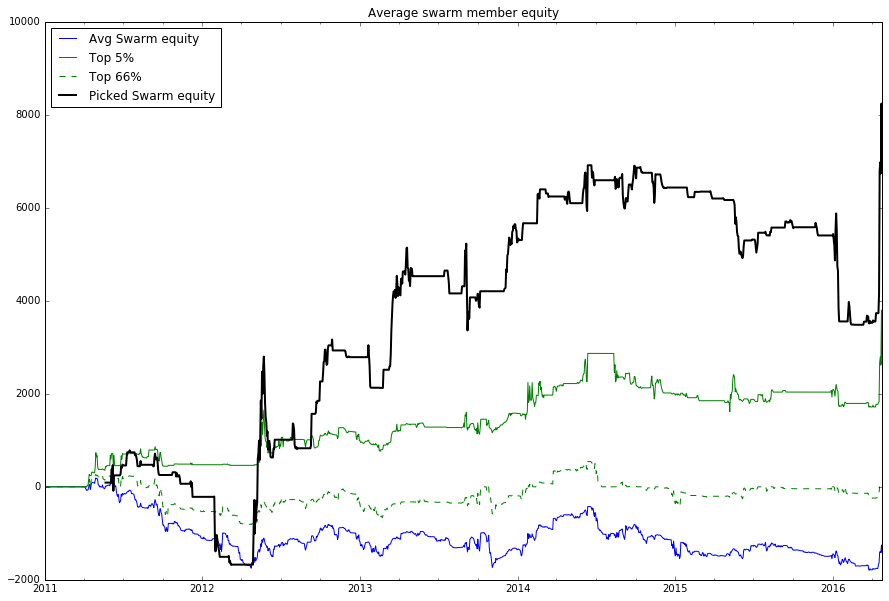

In [271]:
eq_changes = swarm.diff()


is_picked_df = swarm_manager.backtest(swarm)
avg_picked_equity = eq_changes[is_picked_df == 1.0].mean(axis=1).cumsum().ffill()
avg_all_equity = eq_changes.mean(axis=1).cumsum()


avg_all_equity.plot(label='Avg Swarm equity');

swarm.apply(lambda x: np.percentile(x, q=95), axis=1).plot(label='Top 5%', c='g')
swarm.apply(lambda x: np.percentile(x, q=66), axis=1).plot(label='Top 66%', c='g', style='k--')

avg_picked_equity.plot(label='Picked Swarm equity', c='black',linewidth=2)
title('Average swarm member equity');
legend(loc=2)

### Comparing of swarms w/without global filter

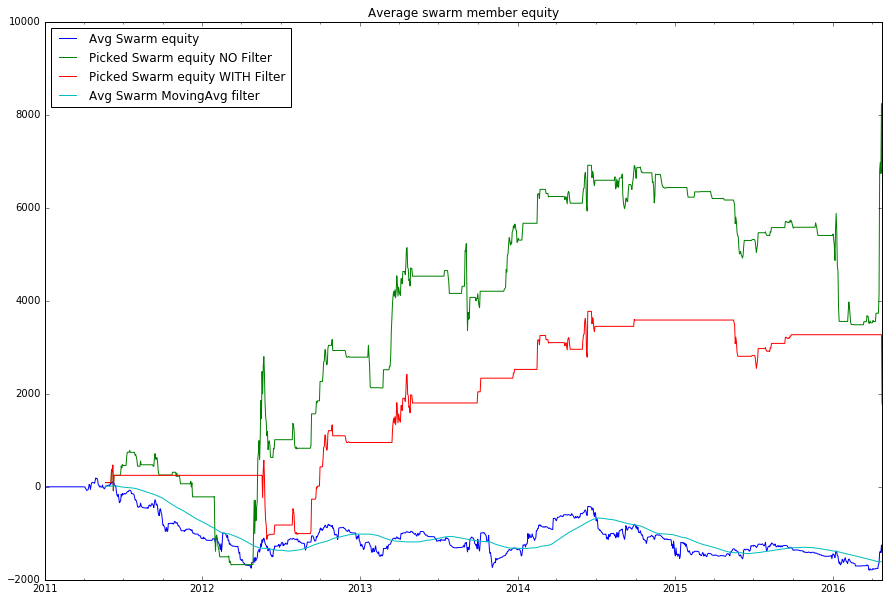

In [272]:
eq_changes = swarm.diff()


is_picked_df_no_filter = swarm_manager.backtest(swarm)
is_picked_df_with_filter = swarm_manager.backtest(swarm, global_filter)

avg_picked_equity_no_filter = eq_changes[is_picked_df_no_filter == 1.0].mean(axis=1).cumsum().ffill()
avg_picked_equity_with_filter = eq_changes[is_picked_df_with_filter == 1.0].mean(axis=1).cumsum().ffill()

avg_all_equity = avg_swarm


avg_all_equity.plot(label='Avg Swarm equity');
avg_picked_equity_no_filter.plot(label='Picked Swarm equity NO Filter')
avg_picked_equity_with_filter.plot(label='Picked Swarm equity WITH Filter')
avg_swarm.rolling(100).mean().plot(label='Avg Swarm MovingAvg filter')
title('Average swarm member equity');
legend(loc=2)

# Money Management and Position sizing reasoning

Let we have 100k USD in account, we are ready to risk about 10% of our cash. 
We should be able to construct portfolio of swarm members which is meets risk constraints.
My envision for such kind work flow:
1.	We should backtest portfolio of swarm members 
2.	Let our R is 1000 USD per 1 volatility unit, to meet risk constraints of 10% of cash we should apply some additional factor Rf (Risk-factor)
3.	We should to do Monte-Carlo simulations to estimate true/fair risk of particular EXO, to know how our swarm portfolio estimates fair risk with its MAE and drawdown. Let simulation estimates fair risk as 20R. That means that generic trading system in our framework potentially will have risk 20R or 20 000 USD.
4.	At next we should calculate Rf =  [Acceptable risk] /  [Fair EXO risk] = 100 000 * 10%  /  20 000 = 0.5 . Rf equal to 0.5 means that we have to open 0.5 of our volatility adjusted size to meet 10% risk constraints.
5.	When we get some profit, for example 10% or 10 000 USD we should increase our size to reinvest the profit, all what we should do is to increase Rf on 10%. New Rf should become 0.55 of our volatility adjusted size. The point is in increasing of Rf when gaining profits and deceasing Rf when we have a losses.


### Money management is not necessary at this stage by design

#### The main reasons

*	Each client’s portfolio can contain many alpha style swarms and EXOs
*	Each client’s portfolio has a different size and risk profile
*	To know size of particular position we should know the risk, to know the risk we should do a backtest, to do a backtest (with Money Management) we should know position size (this is a vicious circle)
*	It is not convenient to compare different backtest results with each other


### The solution

We should create another layer which manages portfolios and calculates position size (i.e. Rf (risk-factor) for each portfolio.

# Generate different starting capital based alpha that demonstrate position sizing effects

### I assume that EXO dollar point values equal to 10.0 USD

In [207]:
#
# Let EXO dollar point values equal to 10.0 USD
#
point_value = 10.0

#
# Let default R=100.0 per vola
#
base_pos_size = strategy.positionsize

#
# Let portfolio 100 000
#
portfolio_size = 100000

#
# Let acceptable risk is 10%
#
portfolio_risk = 0.1

#
# Let the expected Max DrawDown for this type of swarm is 3000
#   (based on MC simulations)
#
expected_dd = 3000

## Calculate Rf (Risk-factor) to fit risk constraints

In [195]:
Rf = (portfolio_size * portfolio_risk ) / expected_dd / point_value

In [196]:
Rf

0.33333333333333337

## Applying Rf and calculating rounded position size

In [197]:
true_pos_size = (strategy.positionsize * Rf).round()

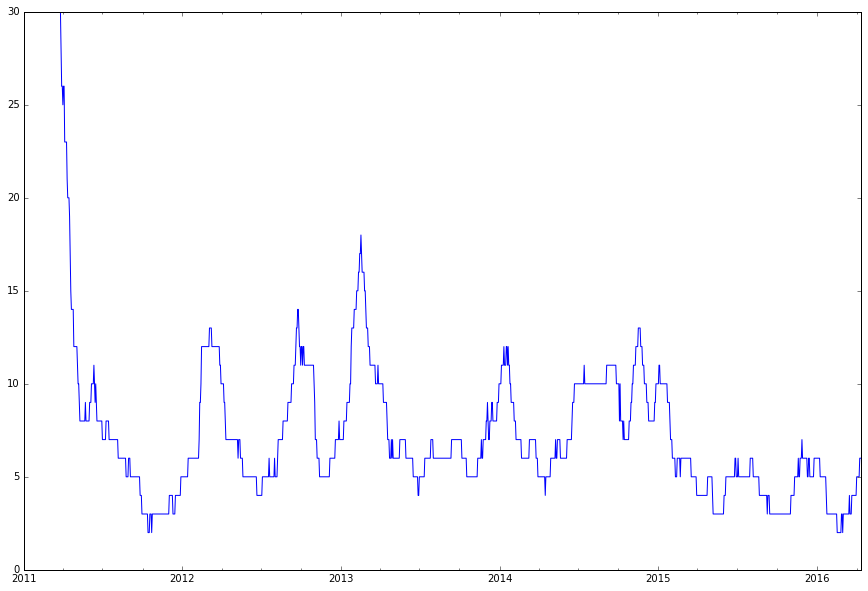

In [198]:
true_pos_size.plot()

In [199]:
true_pos_size.describe()

count    1317.000000
mean        7.103265
std         3.423719
min         2.000000
25%         5.000000
50%         6.000000
75%         9.000000
max        30.000000
Name: exo, dtype: float64

In [206]:
sizes = [100000, 200000, 300000, 500000]

print("Position size estimation\n\n")

for s in sizes:
    _Rf = (s * portfolio_risk ) / expected_dd / point_value
    _true_pos_size = (strategy.positionsize * _Rf).round()
    
    print('Stats for $'+str(s)+" portfolio")
    print(_true_pos_size.describe())
    print('------------------\n')
    

Position size estimation


Stats for $100000 portfolio
count    1317.000000
mean        7.103265
std         3.423719
min         2.000000
25%         5.000000
50%         6.000000
75%         9.000000
max        30.000000
Name: exo, dtype: float64
------------------

Stats for $200000 portfolio
count    1317.000000
mean       14.231587
std         6.859996
min         4.000000
25%        10.000000
50%        12.000000
75%        18.000000
max        61.000000
Name: exo, dtype: float64
------------------

Stats for $300000 portfolio
count    1317.000000
mean       21.312832
std        10.291316
min         7.000000
25%        15.000000
50%        19.000000
75%        27.000000
max        91.000000
Name: exo, dtype: float64
------------------

Stats for $500000 portfolio
count    1317.000000
mean       35.530752
std        17.154182
min        11.000000
25%        25.000000
50%        31.000000
75%        45.000000
max       152.000000
Name: exo, dtype: float64
------------------

